In [1]:
from math import sin, cos
import s2cell
import collections

import numpy as np
import pandas as pd
import datetime as dt

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import pingouin as pg

import warnings
warnings.filterwarnings('ignore')

import category_encoders as ce
import sklearn

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

import warnings
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.max_columns', 500)

%load_ext autotime
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import plotly_express as px
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

In [2]:
test_df = pd.read_csv('data_test.csv')
samp_df = pd.read_csv('sample_submission.csv')

time: 52 ms


In [3]:
df1 = pd.read_csv('merged_df1.csv', parse_dates=['dates_x', 'dates_y'])

time: 39.8 s


In [4]:
df1.head(3)

,Ids,Labels,id_x,pub_millis,s2id_15,s2token_15,road_type,street_x,city_x,magvar,reliability,report_rating,confidence,type_x,subtype,n_thumbs_up_x,longitude,latitude,dates_x,date_x,hour_x,id_y,detection_date_millis,update_date_millis,street_y,city_y,is_highway,line,s2id_center,s2token_center,speed,regular_speed,delay_seconds,seconds,length,trend,type_y,severity,jam_level,drivers_count,alerts_count,n_thumbs_up_y,dates_y,date_y,hour_y
0,2e68e7d0c_2020-10-14_17,1,174293857,1602671462000,3344177607083032576,2e68e7d0c,7,Laswi,Bandung,194,6,5,0,WEATHERHAZARD,HAZARD_ON_SHOULDER_CAR_STOPPED,NaN,107.631025,-6.920342,2020-10-14 17:31:02,2020-10-14,17,12565640,1602671143526,1602672140763,Laswi,Bandung,t,"{""line"": [{""x"": 107.630985, ""y"": -6.917677}, {...",3344177607083032576,2e68e7d0c,4.21,19.21,514,583,683,0,Medium,5,4,5,6,3,2020-10-14 17:25:43.526,2020-10-14,17
1,2e68e7d0c_2020-10-14_17,1,174293857,1602671462000,3344177607083032576,2e68e7d0c,7,Laswi,Bandung,194,6,5,0,WEATHERHAZARD,HAZARD_ON_SHOULDER_CAR_STOPPED,NaN,107.631025,-6.920342,2020-10-14 17:31:02,2020-10-14,17,12565622,1602671143526,1602672062891,Laswi,Bandung,t,"{""line"": [{""x"": 107.630985, ""y"": -6.917677}, {...",3344177607083032576,2e68e7d0c,4.17,18.78,519,588,683,1,Medium,5,4,5,6,2,2020-10-14 17:25:43.526,2020-10-14,17
2,2e68e7d0c_2020-10-14_17,1,174293857,1602671462000,3344177607083032576,2e68e7d0c,7,Laswi,Bandung,194,6,5,0,WEATHERHAZARD,HAZARD_ON_SHOULDER_CAR_STOPPED,NaN,107.631025,-6.920342,2020-10-14 17:31:02,2020-10-14,17,12565631,1602671143526,1602672062891,Laswi,Bandung,t,"{""line"": [{""x"": 107.630985, ""y"": -6.917677}, {...",3344177607083032576,2e68e7d0c,4.17,18.78,519,588,683,1,Medium,5,4,5,6,2,2020-10-14 17:25:43.526,2020-10-14,17


time: 30 ms


In [5]:
def df_processing(data_ml):
    data_ml.rename(columns={'date_x': 'date', 'hour_x': 'hour'}, inplace=True)
    data_ml['date2'] = data_ml['date'].copy()
    
    data_ml['date'] = data_ml['date'].str.split('-')
    
    data_ml['year'] = data_ml['date'].apply(lambda x: int(x[0]))
    data_ml['month'] = data_ml['date'].apply(lambda x: int(x[1]))
    data_ml['day'] = data_ml['date'].apply(lambda x: int(x[2]))
    data_ml['hour'] = data_ml['hour'].astype('int')
    
    data_ml['x'] = data_ml['latitude'].apply(cos) * data_ml['longitude'].apply(cos)
    data_ml['y'] = data_ml['latitude'].apply(cos) * data_ml['longitude'].apply(sin)
    data_ml['z'] = data_ml['latitude'].apply(sin)
    data_ml['date2'] = pd.to_datetime(data_ml['date2'])
    
    data_ml['weekend'] = data_ml['date2'].apply(lambda x: x.weekday() >= 5)
    data_ml['working_hour'] = data_ml['hour'].apply(lambda x: (9<=x<12) | (13<x<18))
    data_ml['high_commute'] = data_ml['hour'].apply(lambda x: (7<=x<=8) | (12<=x<=13) | (18<=x<=19))
    data_ml['op_malam'] = data_ml['hour'].apply(lambda x: (20<=x<=22))
    data_ml['op_ngalong'] = data_ml['hour'].apply(lambda x: (x==23) | (x==0))
    data_ml['op_tidur'] = data_ml['hour'].apply(lambda x: (1<=x<=6))
    data_ml.rename(columns={'street_x': 'street'}, inplace=True)
    
#     data_ml['geo'] = data_ml['latitude'].astype('str') + ', ' + data_ml['longitude'].astype('str')
#     locator = Nominatim(user_agent='myGeocoder', timeout=20)
#     rgeocode = RateLimiter(locator.reverse, min_delay_seconds=0.001)
#     data_ml['address'] = data_ml['geo'].apply(rgeocode)
    
    return data_ml

time: 6 ms


In [6]:
data_ml = df_processing(df1)

time: 31.3 s


In [7]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3188060 entries, 0 to 3188059
Data columns (total 58 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Ids                    object        
 1   Labels                 int64         
 2   id_x                   int64         
 3   pub_millis             int64         
 4   s2id_15                int64         
 5   s2token_15             object        
 6   road_type              int64         
 7   street                 object        
 8   city_x                 object        
 9   magvar                 int64         
 10  reliability            int64         
 11  report_rating          int64         
 12  confidence             int64         
 13  type_x                 object        
 14  subtype                object        
 15  n_thumbs_up_x          float64       
 16  longitude              float64       
 17  latitude               float64       
 18  dates_x               

In [8]:
data_ml.head(3)

,Ids,Labels,id_x,pub_millis,s2id_15,s2token_15,road_type,street,city_x,magvar,reliability,report_rating,confidence,type_x,subtype,n_thumbs_up_x,longitude,latitude,dates_x,date,hour,id_y,detection_date_millis,update_date_millis,street_y,city_y,is_highway,line,s2id_center,s2token_center,speed,regular_speed,delay_seconds,seconds,length,trend,type_y,severity,jam_level,drivers_count,alerts_count,n_thumbs_up_y,dates_y,date_y,hour_y,date2,year,month,day,x,y,z,weekend,working_hour,high_commute,op_malam,op_ngalong,op_tidur
0,2e68e7d0c_2020-10-14_17,1,174293857,1602671462000,3344177607083032576,2e68e7d0c,7,Laswi,Bandung,194,6,5,0,WEATHERHAZARD,HAZARD_ON_SHOULDER_CAR_STOPPED,NaN,107.631025,-6.920342,2020-10-14 17:31:02,"[2020, 10, 14]",17,12565640,1602671143526,1602672140763,Laswi,Bandung,t,"{""line"": [{""x"": 107.630985, ""y"": -6.917677}, {...",3344177607083032576,2e68e7d0c,4.21,19.21,514,583,683,0,Medium,5,4,5,6,3,2020-10-14 17:25:43.526,2020-10-14,17,2020-10-14,2020,10,14,0.550197,0.585971,-0.594912,False,True,False,False,False,False
1,2e68e7d0c_2020-10-14_17,1,174293857,1602671462000,3344177607083032576,2e68e7d0c,7,Laswi,Bandung,194,6,5,0,WEATHERHAZARD,HAZARD_ON_SHOULDER_CAR_STOPPED,NaN,107.631025,-6.920342,2020-10-14 17:31:02,"[2020, 10, 14]",17,12565622,1602671143526,1602672062891,Laswi,Bandung,t,"{""line"": [{""x"": 107.630985, ""y"": -6.917677}, {...",3344177607083032576,2e68e7d0c,4.17,18.78,519,588,683,1,Medium,5,4,5,6,2,2020-10-14 17:25:43.526,2020-10-14,17,2020-10-14,2020,10,14,0.550197,0.585971,-0.594912,False,True,False,False,False,False
2,2e68e7d0c_2020-10-14_17,1,174293857,1602671462000,3344177607083032576,2e68e7d0c,7,Laswi,Bandung,194,6,5,0,WEATHERHAZARD,HAZARD_ON_SHOULDER_CAR_STOPPED,NaN,107.631025,-6.920342,2020-10-14 17:31:02,"[2020, 10, 14]",17,12565631,1602671143526,1602672062891,Laswi,Bandung,t,"{""line"": [{""x"": 107.630985, ""y"": -6.917677}, {...",3344177607083032576,2e68e7d0c,4.17,18.78,519,588,683,1,Medium,5,4,5,6,2,2020-10-14 17:25:43.526,2020-10-14,17,2020-10-14,2020,10,14,0.550197,0.585971,-0.594912,False,True,False,False,False,False


time: 45 ms


In [9]:
data_ml['street'].isna().sum()

96299

time: 152 ms


In [10]:
data_ml.isna().sum()

Ids                            0
Labels                         0
id_x                           0
pub_millis                     0
s2id_15                        0
s2token_15                     0
road_type                      0
street                     96299
city_x                         0
magvar                         0
reliability                    0
report_rating                  0
confidence                     0
type_x                         0
subtype                   159480
n_thumbs_up_x            2401472
longitude                      0
latitude                       0
dates_x                        0
date                           0
hour                           0
id_y                           0
detection_date_millis          0
update_date_millis             0
street_y                   30904
city_y                         0
is_highway                     0
line                           0
s2id_center                    0
s2token_center                 0
speed     

time: 1.88 s


In [11]:
data_ml['street_y'].isna().sum()

30904

time: 123 ms


In [12]:
data_ml['city_y'].value_counts()

Bekasi               1009049
Bandung               947266
Depok                 613124
Bogor                 286737
Tambun Selatan         88030
Parung                 65425
Cikarang               65333
Parongpong             36011
Tangerang Selatan      26764
Cibitung (Bekasi)      15973
Cimahi                  8894
Cibinong                6373
Tarumajaya              6256
Gunung Sindur           5720
Setu (Bekasi)           2840
Tambun Utara            2135
Babelan                  888
Serang Baru              646
Cileungsi                350
Lembang                  246
Name: city_y, dtype: int64

time: 317 ms


In [13]:
data_ml['city_x'].value_counts()

Bekasi               1008915
Bandung               947512
Depok                 613056
Bogor                 286737
Tambun Selatan         88164
Cikarang               65518
Parung                 65425
Parongpong             36011
Tangerang Selatan      26764
Cibitung (Bekasi)      15973
Cimahi                  8894
Cibinong                6441
Tarumajaya              6256
Gunung Sindur           5720
Setu (Bekasi)           2655
Tambun Utara            2135
Babelan                  888
Serang Baru              646
Cileungsi                350
Name: city_x, dtype: int64

time: 313 ms


In [14]:
data_ml1a = data_ml[['Ids', 'Labels', 's2token_15', 'latitude', 'longitude', 'x', 'y', 'z', 'city_y', 'street_y', 'is_highway', 'road_type', 'month', 'day', 'weekend', 'working_hour', 'high_commute', 'op_malam', 'op_ngalong', 'op_tidur']]

time: 1.13 s


In [15]:
data_ml1a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3188060 entries, 0 to 3188059
Data columns (total 20 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Ids           object 
 1   Labels        int64  
 2   s2token_15    object 
 3   latitude      float64
 4   longitude     float64
 5   x             float64
 6   y             float64
 7   z             float64
 8   city_y        object 
 9   street_y      object 
 10  is_highway    object 
 11  road_type     int64  
 12  month         int64  
 13  day           int64  
 14  weekend       bool   
 15  working_hour  bool   
 16  high_commute  bool   
 17  op_malam      bool   
 18  op_ngalong    bool   
 19  op_tidur      bool   
dtypes: bool(6), float64(5), int64(4), object(5)
memory usage: 358.8+ MB
time: 6.01 ms


In [16]:
data_ml1a.isna().sum()

Ids                 0
Labels              0
s2token_15          0
latitude            0
longitude           0
x                   0
y                   0
z                   0
city_y              0
street_y        30904
is_highway          0
road_type           0
month               0
day                 0
weekend             0
working_hour        0
high_commute        0
op_malam            0
op_ngalong          0
op_tidur            0
dtype: int64

time: 700 ms


In [17]:
data_ml1a.dropna(inplace=True)

time: 1.39 s


In [18]:
data_ml1a.isna().sum()

Ids             0
Labels          0
s2token_15      0
latitude        0
longitude       0
x               0
y               0
z               0
city_y          0
street_y        0
is_highway      0
road_type       0
month           0
day             0
weekend         0
working_hour    0
high_commute    0
op_malam        0
op_ngalong      0
op_tidur        0
dtype: int64

time: 639 ms


In [19]:
data_ml1a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3157156 entries, 0 to 3188059
Data columns (total 20 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Ids           object 
 1   Labels        int64  
 2   s2token_15    object 
 3   latitude      float64
 4   longitude     float64
 5   x             float64
 6   y             float64
 7   z             float64
 8   city_y        object 
 9   street_y      object 
 10  is_highway    object 
 11  road_type     int64  
 12  month         int64  
 13  day           int64  
 14  weekend       bool   
 15  working_hour  bool   
 16  high_commute  bool   
 17  op_malam      bool   
 18  op_ngalong    bool   
 19  op_tidur      bool   
dtypes: bool(6), float64(5), int64(4), object(5)
memory usage: 379.4+ MB
time: 6.01 ms


In [20]:
data_ml1a.rename(columns={'city_y': 'city', 'street_y': 'street'}, inplace=True)

time: 29 ms


In [21]:
data_ml1a.head(3)

,Ids,Labels,s2token_15,latitude,longitude,x,y,z,city,street,is_highway,road_type,month,day,weekend,working_hour,high_commute,op_malam,op_ngalong,op_tidur
0,2e68e7d0c_2020-10-14_17,1,2e68e7d0c,-6.920342,107.631025,0.550197,0.585971,-0.594912,Bandung,Laswi,t,7,10,14,False,True,False,False,False,False
1,2e68e7d0c_2020-10-14_17,1,2e68e7d0c,-6.920342,107.631025,0.550197,0.585971,-0.594912,Bandung,Laswi,t,7,10,14,False,True,False,False,False,False
2,2e68e7d0c_2020-10-14_17,1,2e68e7d0c,-6.920342,107.631025,0.550197,0.585971,-0.594912,Bandung,Laswi,t,7,10,14,False,True,False,False,False,False


time: 27 ms


In [22]:
data_ml1a.to_csv('data_ml1a.csv', index=False)

time: 35.5 s


## __Datasets__

> #### X1, y1

In [203]:
X1 = data_ml1a[['city', 'street', 'is_highway', 'road_type', 'month', 'day', 'weekend', 'working_hour', 'high_commute', 'op_malam', 'op_ngalong', 'op_tidur']]
y1 = data_ml1a['Labels']

time: 249 ms


In [204]:
X1.head()

,city,street,is_highway,road_type,month,day,weekend,working_hour,high_commute,op_malam,op_ngalong,op_tidur
0,Bandung,Laswi,t,7,10,14,False,True,False,False,False,False
1,Bandung,Laswi,t,7,10,14,False,True,False,False,False,False
2,Bandung,Laswi,t,7,10,14,False,True,False,False,False,False
3,Bandung,Laswi,t,7,10,14,False,True,False,False,False,False
4,Bandung,Laswi,t,7,10,14,False,True,False,False,False,False


time: 9.99 ms


In [205]:
y1[:5]

0    1
1    1
2    1
3    1
4    1
Name: Labels, dtype: int64

time: 1.99 ms


In [206]:
# Splitting training-validation set dan testing set

X_train_val1, X_test1, y_train_val1, y_test1 = train_test_split(X1,y1,stratify=y1, random_state=2021,test_size=0.2)
skfold = StratifiedKFold(n_splits = 5, random_state=2021, shuffle=True)

time: 2.87 s


> #### X2, y2

In [181]:
X2 = data_ml1a[['x', 'y', 'z', 'month', 'day', 'weekend', 'working_hour', 'high_commute', 'op_malam', 'op_ngalong', 'op_tidur']]
y2 = data_ml1a['Labels']

time: 170 ms


In [182]:
X2.head()

,x,y,z,month,day,weekend,working_hour,high_commute,op_malam,op_ngalong,op_tidur
0,0.550197,0.585971,-0.594912,10,14,False,True,False,False,False,False
1,0.550197,0.585971,-0.594912,10,14,False,True,False,False,False,False
2,0.550197,0.585971,-0.594912,10,14,False,True,False,False,False,False
3,0.550197,0.585971,-0.594912,10,14,False,True,False,False,False,False
4,0.550197,0.585971,-0.594912,10,14,False,True,False,False,False,False


time: 9.99 ms


In [183]:
y2[:5]

0    1
1    1
2    1
3    1
4    1
Name: Labels, dtype: int64

time: 2 ms


In [184]:
# Splitting training-validation set dan testing set

X_train_val2, X_test2, y_train_val2, y_test2 = train_test_split(X2,y2,stratify=y1, random_state=2021,test_size=0.2)
skfold = StratifiedKFold(n_splits = 5, random_state=2021, shuffle=True)

time: 2.06 s


## __Model__

In [103]:
samp_df.head(3)

,Ids,Labels
0,2e69c8bc4_2020-11-29_18,False
1,2e6992f24_2020-11-27_18,True
2,2e69e8dfc_2020-11-28_15,True


time: 5 ms


In [104]:
test_df.head(3)

,Ids
0,2e6992a84_2020-11-25_18
1,2e68e62f4_2020-11-29_20
2,2e68e81a4_2020-11-27_10


time: 4 ms


In [105]:
test_df2 = test_df.copy()

time: 12 ms


In [106]:
test_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13841 entries, 0 to 13840
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Ids     13841 non-null  object
dtypes: object(1)
memory usage: 108.3+ KB
time: 9 ms


In [107]:
test_df2['s2cell_token'] = test_df2['Ids'].str.split('_').apply(lambda x: x[0])
test_df2['date'] = test_df2['Ids'].str.split('_').apply(lambda x: x[1])
test_df2['date2'] = test_df2['date'].str.split('-')
test_df2['hour'] = test_df2['Ids'].str.split('_').apply(lambda x: x[2])

test_df2['year'] = test_df2['date2'].apply(lambda x: int(x[0]))
test_df2['month'] = test_df2['date2'].apply(lambda x: int(x[1]))
test_df2['day'] = test_df2['date2'].apply(lambda x: int(x[2]))
test_df2['hour'] = test_df2['hour'].astype('int')

test_df2['latitude'] = test_df2['s2cell_token'].apply(s2cell.token_to_lat_lon).apply(lambda x: x[0])
test_df2['longitude'] = test_df2['s2cell_token'].apply(s2cell.token_to_lat_lon).apply(lambda x: x[1])

time: 573 ms


In [108]:
test_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13841 entries, 0 to 13840
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ids           13841 non-null  object 
 1   s2cell_token  13841 non-null  object 
 2   date          13841 non-null  object 
 3   date2         13841 non-null  object 
 4   hour          13841 non-null  int32  
 5   year          13841 non-null  int64  
 6   month         13841 non-null  int64  
 7   day           13841 non-null  int64  
 8   latitude      13841 non-null  float64
 9   longitude     13841 non-null  float64
dtypes: float64(2), int32(1), int64(3), object(4)
memory usage: 1.0+ MB
time: 13 ms


In [109]:
data_ml1a[['s2token_15', 'city', 'street', 'is_highway', 'road_type']].duplicated().sum()

3156001

time: 1.28 s


In [110]:
data_ml1a.isna().sum()

Ids             0
Labels          0
s2token_15      0
latitude        0
longitude       0
x               0
y               0
z               0
city            0
street          0
is_highway      0
road_type       0
month           0
day             0
weekend         0
working_hour    0
high_commute    0
op_malam        0
op_ngalong      0
op_tidur        0
dtype: int64

time: 22.4 s


In [93]:
data_ml1a

,Ids,Labels,s2token_15,latitude,longitude,x,y,z,city,street,is_highway,road_type,month,day,weekend,working_hour,high_commute,op_malam,op_ngalong,op_tidur
0,2e68e7d0c_2020-10-14_17,1,2e68e7d0c,-6.920342,107.631025,0.550197,0.585971,-0.594912,Bandung,Laswi,t,7,10,14,False,True,False,False,False,False
1,2e68e7d0c_2020-10-14_17,1,2e68e7d0c,-6.920342,107.631025,0.550197,0.585971,-0.594912,Bandung,Laswi,t,7,10,14,False,True,False,False,False,False
2,2e68e7d0c_2020-10-14_17,1,2e68e7d0c,-6.920342,107.631025,0.550197,0.585971,-0.594912,Bandung,Laswi,t,7,10,14,False,True,False,False,False,False
3,2e68e7d0c_2020-10-14_17,1,2e68e7d0c,-6.920342,107.631025,0.550197,0.585971,-0.594912,Bandung,Laswi,t,7,10,14,False,True,False,False,False,False
4,2e68e7d0c_2020-10-14_17,1,2e68e7d0c,-6.920342,107.631025,0.550197,0.585971,-0.594912,Bandung,Laswi,t,7,10,14,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3188055,2e68e6874_2020-11-22_17,1,2e68e6874,-6.886732,107.581387,0.592657,0.571512,-0.567566,Bandung,Prof Dr Surya Sumantri,f,2,11,22,True,True,False,False,False,False
3188056,2e68e6874_2020-11-22_17,1,2e68e6874,-6.886732,107.581387,0.592657,0.571512,-0.567566,Bandung,Prof Dr Surya Sumantri,f,2,11,22,True,True,False,False,False,False
3188057,2e68e6874_2020-11-22_17,1,2e68e6874,-6.886732,107.581387,0.592657,0.571512,-0.567566,Bandung,Prof Dr Surya Sumantri,f,2,11,22,True,True,False,False,False,False
3188058,2e68e6874_2020-11-22_17,1,2e68e6874,-6.886732,107.581387,0.592657,0.571512,-0.567566,Bandung,Prof Dr Surya Sumantri,f,2,11,22,True,True,False,False,False,False


time: 87 ms


In [111]:
result = pd.merge(test_df2, data_ml1a[['s2token_15', 'city', 'street', 'is_highway', 'road_type']].drop_duplicates(), left_on='s2cell_token', right_on='s2token_15', how='left', indicator=True)

time: 1.28 s


In [112]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16326 entries, 0 to 16325
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Ids           16326 non-null  object  
 1   s2cell_token  16326 non-null  object  
 2   date          16326 non-null  object  
 3   date2         16326 non-null  object  
 4   hour          16326 non-null  int32   
 5   year          16326 non-null  int64   
 6   month         16326 non-null  int64   
 7   day           16326 non-null  int64   
 8   latitude      16326 non-null  float64 
 9   longitude     16326 non-null  float64 
 10  s2token_15    9686 non-null   object  
 11  city          9686 non-null   object  
 12  street        9686 non-null   object  
 13  is_highway    9686 non-null   object  
 14  road_type     9686 non-null   float64 
 15  _merge        16326 non-null  category
dtypes: category(1), float64(3), int32(1), int64(3), object(8)
memory usage: 1.9+ MB
time: 17 ms


In [72]:
# result.to_csv('data_ml1a_result.csv', index=False)

time: 340 ms


In [113]:
result.groupby(['Ids', 'city']).count()

,,s2cell_token,date,date2,hour,year,month,day,latitude,longitude,s2token_15,street,is_highway,road_type,_merge
Ids,city,,,,,,,,,,,,,,
2e68c2a64_2020-11-27_18,Bandung,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2e68dd384_2020-11-23_13,Bandung,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2e68dd384_2020-11-24_19,Bandung,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2e68dd384_2020-11-26_13,Bandung,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2e68dd384_2020-11-26_14,Bandung,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2e69f2d4c_2020-11-28_10,Bekasi,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2e69f2d4c_2020-11-28_14,Bekasi,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2e69f2d4c_2020-11-28_16,Bekasi,4,4,4,4,4,4,4,4,4,4,4,4,4,4


time: 45 ms


In [114]:
result['Ids'].nunique()

13841

time: 6 ms


In [115]:
pd.crosstab(result['Ids'], result['city'])

city,Bandung,Bekasi,Bogor,Cibinong,Cibitung (Bekasi),Cikarang,Cileungsi,Cimahi,Depok,Gunung Sindur,Parongpong,Parung,Serang Baru,Setu (Bekasi),Tambun Selatan,Tambun Utara,Tangerang Selatan,Tarumajaya
Ids,,,,,,,,,,,,,,,,,,
2e68c2a64_2020-11-27_18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2e68dd384_2020-11-23_13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2e68dd384_2020-11-24_19,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2e68dd384_2020-11-26_13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2e68dd384_2020-11-26_14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2e69f2d4c_2020-11-28_10,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2e69f2d4c_2020-11-28_14,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2e69f2d4c_2020-11-28_16,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


time: 145 ms


In [116]:
pd.crosstab(result['Ids'], result['street']).describe()

street,Abdul Rahman Saleh,Achmad Adnawijaya,Alternatif JORR Tol Jatiwarna,Anugerah Raya,Arah Bekasi/Cikampek/Bandung,Arah Bintara/Cilincing/Tanjung Priok/Bogor,Arah Cikarang Barat/Lemahabang,Arah Jakarta/Bogor,Arah Jakarta/Bogor (Lewat Jalan Tol),Arah Kalimalang/Pd Kelapa,Arah Tol Jagorawi/Tol Serpong,Arah Tol Jkt-Cikampek/Bekasi/Tol Purbaleunyi,Arah Tol Lkr Luar/TMII/Cawang,Asem Raya,Asia Afrika,Astana Anyar,Batu Tulis,Benda,Binamarga,Bintara Raya,Brigjen Haji Saptadji Hadiprawira,Buah Batu,Bukit Cinere,Bukit Raya,Caman Raya,Caringin,Chairil Anwar,Cibaduyut Raya,Cibarusah Raya,Cibolerang,Cigondewah Rahayu,Cihampelas,Cikutra Barat,Cilangkap Tapos,Cinere Raya,Cipayung Raya,Cipendawa Baru,Ciumbuleuit,Curug Agung,Dadali,Dago Giri,Dalem Kaum,Dipati Ukur,Dr Djundjunan,Dr Rum,Dr Setiabudi,Exit 04: Pondok Gede/Jatiwaringin/Pondok Kelapa,Exit 10: Jakasampurna/Jatibening/Kranji,Exit 14: Bekasi Barat/Pekayon,Exit 16: Bekasi Timur/Bulak Kapal/Bantar Gebang,Exit 24: Cibitung/Kws Industri,Exit 41; Jati Asih/Cikunir/Jati Mekar,Exit Baranangsiang,Exit Bekasi Barat/Pekayon,Exit Cikarang Barat/Lemahabang,Exit Jati Asih/Cikunir/Jati Mekar,Exit Jati Warna/Kranggan,Exit Kawasan MM2100,Fly Over Simpang Cipendawa,Flyover Cibarusah,Flyover Kiaracondong,Gatot Subroto,Gempol Sari,Gerbang Tol Buah Batu,Gerbang Tol Cikunir,Gerbang Tol Mohammad Toha,Gerbang Tol Pasir Koja,HM Joyomartono,HOS Cokroaminoto,Haji Abu Bakar,Haji Bosih Raya,Haji Djole,Haji Mawi,Hankam Raya,Holis,I Gusti Ngurah Rai,Indrayasa,Industri Pasir Gombong,Industri Raya,Inspeksi Kanal Timur,Ir H Juanda,Ir Haji Juanda,Jababeka Raya,Jalan ABC,Jalan Banda,Jalan Empang,Jalan Gunung Batu,Jalan Inspeksi BKT,Jalan Inspeksi Kalimalang,Jalan Jakarta,Jalan Jatiasih,Jalan Jawa,Jalan Kalimalang,Jalan Kampung Sawah Raya,Jalan Purwakarta,Jalan Raya Bogor,Jalan Raya Lemah Abang,Jati Makmur,Jati Mekar,Jatibening,Jatibening Raya,Jatimulya - Pengasinan,Jatiranggon,Jatiwaringin Raya,Jenderal AH Nasution,Jenderal Ahmad Yani,Jenderal Ibrahim Adjie,Jenderal Sudirman,KH Agus Salim,KH Muchtar Tabrani,KH Noer Ali,KH Wahid Hasyim,Kaliabang,Kalimalang (Cibitung-Cikarang),Kalimanggis,Kampung Utan Raya,Kapten Muslihat,Kapten Tata Natanegara,Kapten Yusuf,Karangsatria Raya,Karawitan,Keadilan Raya,Kemakmuran,Kincan Raya,Komjen Pol M Jasin,Kopo,Kranggan Raya,Krukut Raya,LLRE Martadinata,Lambang Jaya,Laswi,Layang Pasupati,Lengkong Besar,Letjen Suprapto,Leuwinanggung,MH Thamrin,MM2100 - Maspion,Margacinta,Margonda Raya,Mayor Madmuin Hasibuan,Merdeka,Mohammad Toha,Muchtar Raya,Muhtar Raya,Mustikajaya Raya,Mutiara Gading,N1 Cut Mutia,N1 Fatahillah,N1 Flyover Kranji,N1 Gatot Subroto,N1 Imam Bonjol,N1 Ir H Juanda,N1 Jalan Raya Bekasi,N1 Jenderal Ahmad Yani,N1 Jenderal Sudirman,N1 Pangeran Diponegoro,N1 RE Martadinata,N1 Sultan Agung,N1 Sultan Hasanudin,N1 Teuku Umar,N11 Flyover Cimindi,N11 Jenderal Haji Amir Machmud,N11 Soekarno-Hatta,N6 Cinangka Raya,N6 Jalan Raya Parung-Bogor,N6 RE Martadinata,N6 Underpass KH Soleh Iskandar,N8 Jalan Raya Bogor,N9 Jalak Harupat,N9 Jalan Raya Dramaga,N9 Jalan Raya Pajajaran,N9 Jalan Raya Tajur,N9 KH Soleh Iskandar,N9 KH Soleh Iskandar (Jalur Lambat),N9 KS Tubun,N9 Otto Iskandardinata,N9 Raden KH Abdullah bin Nuh,N9 Underpass KH Soleh Iskandar,Narogong Raya,Nusantara,Orange County Blvd,Otto Iskandardinata,PHH Mustofa,Pagermaneuh,Pahlawan,Pahlawan (Jalur Lambat),Pajajaran,Palakali - Kukusan,Paledang,Pandawa Raya,Pasar Kecapi,Pasirmuncang,Pasteur,Patriot,Pejuang,Pekayon Jaya,Pelajar Pejuang 45,Pemuda,Pengasinan,Perjuangan,Permata,Peta,Prof Dr Surya Sumantri,Pulo Empang,Pulo Ribung,Putri Tunggal,RA Wiranatakusumah,RE Abdullah,Rajawali Timur,Ratna,Sawangan Raya,Sekejati,Semplak Raya,Sentosa Raya,Sersan Aswan,Sersan Bajuri,Setia Mekar,Siliwangi,Sirnamanah,Soekarno-Hatta (Jalur Lambat),Sukajadi,Sukaraja,Sumberjaya Raya,Surapati,Surya Kencana,Swatantra 5,Taman Harapan Baru,Tanah Baru,Tanjakan Kembar,Tapos Raya,Tegallega,Terusan Buah Batu,Terusan Jakarta,Terusan Kiaracondong,Terusan Pasir Koja,Tole Is

time: 864 ms


In [117]:
# df_out[df_out.duplicated('Name', keep=False)]

Error in callback <function LineWatcher.stop at 0x0000027F7B666E50> (for post_run_cell):


AssertionError: 

In [118]:
result.duplicated(['street'], keep='first')

0        False
1        False
2        False
3        False
4        False
         ...  
16321     True
16322     True
16323     True
16324     True
16325     True
Length: 16326, dtype: bool

time: 5.99 ms


In [119]:
result['s2cell_token'].nunique()

1958

time: 4.99 ms


In [120]:
result['street'].nunique()

240

time: 3.99 ms


In [121]:
result[result['street']==np.nan]

,Ids,s2cell_token,date,date2,hour,year,month,day,latitude,longitude,s2token_15,city,street,is_highway,road_type,_merge


time: 6 ms


In [122]:
result['Ids'].unique()

array(['2e6992a84_2020-11-25_18', '2e68e62f4_2020-11-29_20',
       '2e68e81a4_2020-11-27_10', ..., '2e69e8e0c_2020-11-24_10',
       '2e699a1cc_2020-11-24_18', '2e698d804_2020-11-25_19'], dtype=object)

time: 4.99 ms


In [123]:
result[result.duplicated(['Ids'])]

,Ids,s2cell_token,date,date2,hour,year,month,day,latitude,longitude,s2token_15,city,street,is_highway,road_type,_merge
1,2e6992a84_2020-11-25_18,2e6992a84,2020-11-25,"[2020, 11, 25]",18,2020,11,25,-6.297106,106.922580,2e6992a84,Bekasi,Pasar Kecapi,f,2.0,both
4,2e68e81a4_2020-11-27_10,2e68e81a4,2020-11-27,"[2020, 11, 27]",10,2020,11,27,-6.940520,107.658527,2e68e81a4,Bandung,N11 Soekarno-Hatta,t,6.0,both
21,2e698cf94_2020-11-27_19,2e698cf94,2020-11-27,"[2020, 11, 27]",19,2020,11,27,-6.247482,106.955045,2e698cf94,Bekasi,Arah Kalimalang/Pd Kelapa,f,2.0,both
22,2e698cf94_2020-11-27_19,2e698cf94,2020-11-27,"[2020, 11, 27]",19,2020,11,27,-6.247482,106.955045,2e698cf94,Bekasi,Arah Kalimalang/Pd Kelapa,f,4.0,both
26,2e68e794c_2020-11-28_7,2e68e794c,2020-11-28,"[2020, 11, 28]",7,2020,11,28,-6.904823,107.649648,2e68e794c,Bandung,Jenderal Ahmad Yani,t,7.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16307,2e68e6684_2020-11-25_13,2e68e6684,2020-11-25,"[2020, 11, 25]",13,2020,11,25,-6.899121,107.596378,2e68e6684,Bandung,Layang Pasupati,t,6.0,both
16308,2e68e6684_2020-11-25_13,2e68e6684,2020-11-25,"[2020, 11, 25]",13,2020,11,25,-6.899121,107.596378,2e68e6684,Bandung,Layang Pasupati,t,7.0,both
16309,2e68e6684_2020-11-25_13,2e68e6684,2020-11-25,"[2020, 11, 25]",13,2020,11,25,-6.899121,107.596378,2e68e6684,Bandung,Dr Djundjunan,t,6.0,both
16314,2e69e9244_2020-11-29_19,2e69e9244,2020-11-29,"[2020, 11, 29]",19,2020,11,29,-6.396620,106.778019,2e69e9244,Depok,Sawangan Raya,t,20.0,both


time: 28 ms


In [124]:
collections.Counter(result['street']).items()

dict_items([('Hankam Raya', 131), ('Pasar Kecapi', 14), ('Asia Afrika', 12), ('Soekarno-Hatta (Jalur Lambat)', 201), ('N11 Soekarno-Hatta', 546), (nan, 6640), ('Holis', 102), ('Caman Raya', 42), ('Wibawa Mukti 2', 171), ('N8 Jalan Raya Bogor', 164), ('Cibarusah Raya', 323), ('Arah Bintara/Cilincing/Tanjung Priok/Bogor', 20), ('Arah Kalimalang/Pd Kelapa', 40), ('KH Muchtar Tabrani', 76), ('Cibaduyut Raya', 32), ('Jenderal Ahmad Yani', 86), ('Narogong Raya', 281), ('Muhtar Raya', 198), ('Jalan Raya Lemah Abang', 17), ('KH Noer Ali', 442), ('N1 Jenderal Ahmad Yani', 103), ('Pejuang', 142), ('Gempol Sari', 8), ('Cinere Raya', 84), ('Jalan Jatiasih', 159), ('N9 Raden KH Abdullah bin Nuh', 41), ('Brigjen Haji Saptadji Hadiprawira', 7), ('Kranggan Raya', 43), ('Jalan Jawa', 41), ('Dago Giri', 11), ('Prof Dr Surya Sumantri', 62), ('Ir Haji Juanda', 180), ('Buah Batu', 64), ('Muchtar Raya', 119), ('Sawangan Raya', 317), ('N6 Cinangka Raya', 75), ('Tanjakan Kembar', 9), ('Margonda Raya', 43), ('

time: 4.99 ms


In [125]:
# collections.Counter(result['Ids'])

Error in callback <function LineWatcher.stop at 0x0000027F7B666E50> (for post_run_cell):


AssertionError: 

In [126]:
len(list(collections.Counter(result['street']).items()))

241

time: 4.99 ms


In [127]:
# result[result.Ids.isin(set(test_df.Ids)) & ~(result._merge==['right_only', 'both'])]  # ngaco

Error in callback <function LineWatcher.stop at 0x0000027F7B666E50> (for post_run_cell):


AssertionError: 

In [128]:
test_df['Ids'].nunique()

13841

time: 6.01 ms


In [129]:
result[(result['month']==11) & ((result['day']>=23) | (result['day']<=29))]

,Ids,s2cell_token,date,date2,hour,year,month,day,latitude,longitude,s2token_15,city,street,is_highway,road_type,_merge
0,2e6992a84_2020-11-25_18,2e6992a84,2020-11-25,"[2020, 11, 25]",18,2020,11,25,-6.297106,106.922580,2e6992a84,Bekasi,Hankam Raya,f,2.0,both
1,2e6992a84_2020-11-25_18,2e6992a84,2020-11-25,"[2020, 11, 25]",18,2020,11,25,-6.297106,106.922580,2e6992a84,Bekasi,Pasar Kecapi,f,2.0,both
2,2e68e62f4_2020-11-29_20,2e68e62f4,2020-11-29,"[2020, 11, 29]",20,2020,11,29,-6.921727,107.611174,2e68e62f4,Bandung,Asia Afrika,t,7.0,both
3,2e68e81a4_2020-11-27_10,2e68e81a4,2020-11-27,"[2020, 11, 27]",10,2020,11,27,-6.940520,107.658527,2e68e81a4,Bandung,Soekarno-Hatta (Jalur Lambat),t,6.0,both
4,2e68e81a4_2020-11-27_10,2e68e81a4,2020-11-27,"[2020, 11, 27]",10,2020,11,27,-6.940520,107.658527,2e68e81a4,Bandung,N11 Soekarno-Hatta,t,6.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16321,2e68dd414_2020-11-26_5,2e68dd414,2020-11-26,"[2020, 11, 26]",5,2020,11,26,-6.908506,107.688127,2e68dd414,Bandung,Jenderal AH Nasution,t,6.0,both
16322,2e698541c_2020-11-24_22,2e698541c,2020-11-24,"[2020, 11, 24]",22,2020,11,24,-6.270080,107.120391,NaN,NaN,NaN,NaN,NaN,left_only
16323,2e69e8e0c_2020-11-24_10,2e69e8e0c,2020-11-24,"[2020, 11, 24]",10,2020,11,24,-6.404702,106.766222,2e69e8e0c,Depok,Muhtar Raya,t,7.0,both
16324,2e699a1cc_2020-11-24_18,2e699a1cc,2020-11-24,"[2020, 11, 24]",18,2020,11,24,-6.367375,107.114484,2e699a1cc,Cikarang,Cibarusah Raya,t,7.0,both


time: 31 ms


In [130]:
result[result['_merge']=='left_only']

,Ids,s2cell_token,date,date2,hour,year,month,day,latitude,longitude,s2token_15,city,street,is_highway,road_type,_merge
5,2e69eec04_2020-11-24_7,2e69eec04,2020-11-24,"[2020, 11, 24]",7,2020,11,24,-6.362827,106.792766,NaN,NaN,NaN,NaN,NaN,left_only
6,2e698e4a4_2020-11-27_8,2e698e4a4,2020-11-27,"[2020, 11, 27]",8,2020,11,27,-6.269891,107.049514,NaN,NaN,NaN,NaN,NaN,left_only
7,2e68ef55c_2020-11-26_19,2e68ef55c,2020-11-26,"[2020, 11, 26]",19,2020,11,26,-6.931024,107.569747,NaN,NaN,NaN,NaN,NaN,left_only
10,2e698d434_2020-11-28_13,2e698d434,2020-11-28,"[2020, 11, 28]",13,2020,11,28,-6.284032,106.931433,NaN,NaN,NaN,NaN,NaN,left_only
12,2e69c5a44_2020-11-26_23,2e69c5a44,2020-11-26,"[2020, 11, 26]",23,2020,11,26,-6.601969,106.778019,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16315,2e6996614_2020-11-27_15,2e6996614,2020-11-27,"[2020, 11, 27]",15,2020,11,27,-6.419005,107.025893,NaN,NaN,NaN,NaN,NaN,left_only
16316,2e68e8c8c_2020-11-24_12,2e68e8c8c,2020-11-24,"[2020, 11, 24]",12,2020,11,24,-6.953643,107.584542,NaN,NaN,NaN,NaN,NaN,left_only
16319,2e69ef014_2020-11-26_19,2e69ef014,2020-11-26,"[2020, 11, 26]",19,2020,11,26,-6.345782,106.766222,NaN,NaN,NaN,NaN,NaN,left_only
16320,2e68e8864_2020-11-25_15,2e68e8864,2020-11-25,"[2020, 11, 25]",15,2020,11,25,-6.936950,107.617093,NaN,NaN,NaN,NaN,NaN,left_only


time: 26 ms


In [131]:
result[result['_merge']=='left_only']['Ids'].nunique()

6640

time: 7 ms


In [132]:
result

,Ids,s2cell_token,date,date2,hour,year,month,day,latitude,longitude,s2token_15,city,street,is_highway,road_type,_merge
0,2e6992a84_2020-11-25_18,2e6992a84,2020-11-25,"[2020, 11, 25]",18,2020,11,25,-6.297106,106.922580,2e6992a84,Bekasi,Hankam Raya,f,2.0,both
1,2e6992a84_2020-11-25_18,2e6992a84,2020-11-25,"[2020, 11, 25]",18,2020,11,25,-6.297106,106.922580,2e6992a84,Bekasi,Pasar Kecapi,f,2.0,both
2,2e68e62f4_2020-11-29_20,2e68e62f4,2020-11-29,"[2020, 11, 29]",20,2020,11,29,-6.921727,107.611174,2e68e62f4,Bandung,Asia Afrika,t,7.0,both
3,2e68e81a4_2020-11-27_10,2e68e81a4,2020-11-27,"[2020, 11, 27]",10,2020,11,27,-6.940520,107.658527,2e68e81a4,Bandung,Soekarno-Hatta (Jalur Lambat),t,6.0,both
4,2e68e81a4_2020-11-27_10,2e68e81a4,2020-11-27,"[2020, 11, 27]",10,2020,11,27,-6.940520,107.658527,2e68e81a4,Bandung,N11 Soekarno-Hatta,t,6.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16321,2e68dd414_2020-11-26_5,2e68dd414,2020-11-26,"[2020, 11, 26]",5,2020,11,26,-6.908506,107.688127,2e68dd414,Bandung,Jenderal AH Nasution,t,6.0,both
16322,2e698541c_2020-11-24_22,2e698541c,2020-11-24,"[2020, 11, 24]",22,2020,11,24,-6.270080,107.120391,NaN,NaN,NaN,NaN,NaN,left_only
16323,2e69e8e0c_2020-11-24_10,2e69e8e0c,2020-11-24,"[2020, 11, 24]",10,2020,11,24,-6.404702,106.766222,2e69e8e0c,Depok,Muhtar Raya,t,7.0,both
16324,2e699a1cc_2020-11-24_18,2e699a1cc,2020-11-24,"[2020, 11, 24]",18,2020,11,24,-6.367375,107.114484,2e699a1cc,Cikarang,Cibarusah Raya,t,7.0,both


time: 24 ms


In [133]:
result['date'] = pd.to_datetime(result['date'])
result['weekend'] = result['date'].apply(lambda x: x.weekday() >= 5)

time: 76 ms


In [134]:
result['working_hour'] = result['hour'].apply(lambda x: (9<=x<12) | (13<x<18))
result['high_commute'] = result['hour'].apply(lambda x: (7<=x<=8) | (12<=x<=13) | (18<=x<=19))
result['op_malam'] = result['hour'].apply(lambda x: (20<=x<=22))
result['op_ngalong'] = result['hour'].apply(lambda x: (x==23) | (x==0))
result['op_tidur'] = result['hour'].apply(lambda x: (1<=x<=6))

time: 26 ms


In [135]:
tes1 = result.drop_duplicates('Ids')

time: 12 ms


In [136]:
pred1 = tes1[['city', 'street', 'is_highway', 'road_type', 'month', 'day', 'weekend', 'working_hour', 'high_commute', 'op_malam', 'op_ngalong', 'op_tidur']]

time: 45 ms


In [137]:
pred1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13841 entries, 0 to 16325
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          7201 non-null   object 
 1   street        7201 non-null   object 
 2   is_highway    7201 non-null   object 
 3   road_type     7201 non-null   float64
 4   month         13841 non-null  int64  
 5   day           13841 non-null  int64  
 6   weekend       13841 non-null  bool   
 7   working_hour  13841 non-null  bool   
 8   high_commute  13841 non-null  bool   
 9   op_malam      13841 non-null  bool   
 10  op_ngalong    13841 non-null  bool   
 11  op_tidur      13841 non-null  bool   
dtypes: bool(6), float64(1), int64(2), object(3)
memory usage: 838.0+ KB
time: 10 ms


In [138]:
pred1

,city,street,is_highway,road_type,month,day,weekend,working_hour,high_commute,op_malam,op_ngalong,op_tidur
0,Bekasi,Hankam Raya,f,2.0,11,25,False,False,True,False,False,False
2,Bandung,Asia Afrika,t,7.0,11,29,True,False,False,True,False,False
3,Bandung,Soekarno-Hatta (Jalur Lambat),t,6.0,11,27,False,True,False,False,False,False
5,NaN,NaN,NaN,NaN,11,24,False,False,True,False,False,False
6,NaN,NaN,NaN,NaN,11,27,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
16321,Bandung,Jenderal AH Nasution,t,6.0,11,26,False,False,False,False,False,True
16322,NaN,NaN,NaN,NaN,11,24,False,False,False,True,False,False
16323,Depok,Muhtar Raya,t,7.0,11,24,False,True,False,False,False,False
16324,Cikarang,Cibarusah Raya,t,7.0,11,24,False,False,True,False,False,False


time: 16 ms


In [139]:
result['day']

0        25
1        25
2        29
3        27
4        27
         ..
16321    26
16322    24
16323    24
16324    24
16325    25
Name: day, Length: 16326, dtype: int64

time: 2.99 ms


In [140]:
data_ml1a['day']

0          14
1          14
2          14
3          14
4          14
           ..
3188055    22
3188056    22
3188057    22
3188058    22
3188059    22
Name: day, Length: 3157156, dtype: int64

time: 3 ms


In [141]:
result['day'].value_counts()

28    3500
27    2624
25    2361
29    2247
26    2096
24    1800
23    1698
Name: day, dtype: int64

time: 1.99 ms


In [142]:
data_ml1a['day'].value_counts()

29    236105
30    201603
26    193023
7     180009
2     158102
4     145337
10    134792
3     129099
27    124128
20    121212
8     111188
31    105271
5     103776
25     89400
9      83242
14     81294
6      79919
21     78161
11     78080
17     76076
16     73932
1      73418
28     68218
13     65515
23     63198
24     59250
15     58903
18     55187
22     50344
19     42618
12     36756
Name: day, dtype: int64

time: 32 ms


In [143]:
result

,Ids,s2cell_token,date,date2,hour,year,month,day,latitude,longitude,s2token_15,city,street,is_highway,road_type,_merge,weekend,working_hour,high_commute,op_malam,op_ngalong,op_tidur
0,2e6992a84_2020-11-25_18,2e6992a84,2020-11-25,"[2020, 11, 25]",18,2020,11,25,-6.297106,106.922580,2e6992a84,Bekasi,Hankam Raya,f,2.0,both,False,False,True,False,False,False
1,2e6992a84_2020-11-25_18,2e6992a84,2020-11-25,"[2020, 11, 25]",18,2020,11,25,-6.297106,106.922580,2e6992a84,Bekasi,Pasar Kecapi,f,2.0,both,False,False,True,False,False,False
2,2e68e62f4_2020-11-29_20,2e68e62f4,2020-11-29,"[2020, 11, 29]",20,2020,11,29,-6.921727,107.611174,2e68e62f4,Bandung,Asia Afrika,t,7.0,both,True,False,False,True,False,False
3,2e68e81a4_2020-11-27_10,2e68e81a4,2020-11-27,"[2020, 11, 27]",10,2020,11,27,-6.940520,107.658527,2e68e81a4,Bandung,Soekarno-Hatta (Jalur Lambat),t,6.0,both,False,True,False,False,False,False
4,2e68e81a4_2020-11-27_10,2e68e81a4,2020-11-27,"[2020, 11, 27]",10,2020,11,27,-6.940520,107.658527,2e68e81a4,Bandung,N11 Soekarno-Hatta,t,6.0,both,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16321,2e68dd414_2020-11-26_5,2e68dd414,2020-11-26,"[2020, 11, 26]",5,2020,11,26,-6.908506,107.688127,2e68dd414,Bandung,Jenderal AH Nasution,t,6.0,both,False,False,False,False,False,True
16322,2e698541c_2020-11-24_22,2e698541c,2020-11-24,"[2020, 11, 24]",22,2020,11,24,-6.270080,107.120391,NaN,NaN,NaN,NaN,NaN,left_only,False,False,False,True,False,False
16323,2e69e8e0c_2020-11-24_10,2e69e8e0c,2020-11-24,"[2020, 11, 24]",10,2020,11,24,-6.404702,106.766222,2e69e8e0c,Depok,Muhtar Raya,t,7.0,both,False,True,False,False,False,False
16324,2e699a1cc_2020-11-24_18,2e699a1cc,2020-11-24,"[2020, 11, 24]",18,2020,11,24,-6.367375,107.114484,2e699a1cc,Cikarang,Cibarusah Raya,t,7.0,both,False,False,True,False,False,False


time: 30 ms


In [144]:
# commented out first

# # test_df2 = pd.DataFrame()
# test_df2['s2cell_token'] = test_df2['Ids'].str.split('_').apply(lambda x: x[0])
# test_df2['date'] = test_df2['Ids'].str.split('_').apply(lambda x: x[1])
# test_df2['date'] = test_df2['date'].str.split('-')
# test_df2['hour'] = test_df2['Ids'].str.split('_').apply(lambda x: x[2])

# test_df2['year'] = test_df2['date'].apply(lambda x: int(x[0]))
# test_df2['month'] = test_df2['date'].apply(lambda x: int(x[1]))
# test_df2['day'] = test_df2['date'].apply(lambda x: int(x[2]))
# test_df2['hour'] = test_df2['hour'].astype('int')

# test_df2['latitude'] = test_df2['s2cell_token'].apply(s2cell.token_to_lat_lon).apply(lambda x: x[0])
# test_df2['longitude'] = test_df2['s2cell_token'].apply(s2cell.token_to_lat_lon).apply(lambda x: x[1])
# test_df2['city'] = test_df2['s2cell_token'].apply(lambda x: data_ml1a[data_ml1a['s2token_15']==x]['city'])


# # test_df2 = test_df2[['x', 'y', 'z', 'year', 'month', 'day', 'hour']]
# test_df2

time: 1 ms


In [145]:
# commented out first

# # test_df2['s2cell_token'][0]
# data_ml1a[data_ml1a['s2token_15']==test_df2['s2cell_token'][0]]['city']

time: 1e+03 µs


In [146]:
# commented out first

# # Creating function to convert Ids Table into Proper Independent DF Table for Testing

# def ids_to_df(df):
#     test_df2 = pd.DataFrame()
#     test_df2['s2cell_token'] = df['Ids'].str.split('_').apply(lambda x: x[0])
#     test_df2['date'] = df['Ids'].str.split('_').apply(lambda x: x[1])
#     test_df2['date'] = test_df2['date'].str.split('-')
#     test_df2['hour'] = df['Ids'].str.split('_').apply(lambda x: x[2])
    
#     test_df2['year'] = test_df2['date'].apply(lambda x: int(x[0]))
#     test_df2['month'] = test_df2['date'].apply(lambda x: int(x[1]))
#     test_df2['day'] = test_df2['date'].apply(lambda x: int(x[2]))
#     test_df2['hour'] = test_df2['hour'].astype('int')
    
#     test_df2['latitude'] = test_df2['s2cell_token'].apply(s2cell.token_to_lat_lon).apply(lambda x: x[0])
#     test_df2['longitude'] = test_df2['s2cell_token'].apply(s2cell.token_to_lat_lon).apply(lambda x: x[1])
    
# #     test_df2['x'] = test_df2['latitude'].apply(cos) * test_df2['longitude'].apply(cos)
# #     test_df2['y'] = test_df2['latitude'].apply(cos) * test_df2['longitude'].apply(sin)
# #     test_df2['z'] = test_df2['latitude'].apply(sin)
    
#     test_df2 = test_df2[['x', 'y', 'z', 'year', 'month', 'day', 'hour']]
    
#     return test_df2

Error in callback <function LineWatcher.stop at 0x0000027F7B666E50> (for post_run_cell):


AssertionError: 

> #### Logit Tuned - smote, threshold

In [147]:
pred1a_test = pd.read_csv('pred1a_test.csv')

time: 38 ms


In [148]:
pred1a_test

,city,street,is_highway,road_type,month,day,weekend,working_hour,high_commute,op_malam,op_ngalong,op_tidur
0,Bekasi,Hankam Raya,f,2.0,11,25,False,False,True,False,False,False
1,Bandung,Asia Afrika,t,7.0,11,29,True,False,False,True,False,False
2,Bandung,Soekarno-Hatta (Jalur Lambat),t,6.0,11,27,False,True,False,False,False,False
3,Depok,Krukut Raya,f,2.0,11,24,False,False,True,False,False,False
4,Tambun Selatan,Haji Abu Bakar,f,2.0,11,27,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
13836,Bandung,Jenderal AH Nasution,t,6.0,11,26,False,False,False,False,False,True
13837,NaN,NaN,NaN,NaN,11,24,False,False,False,True,False,False
13838,Depok,Muhtar Raya,t,7.0,11,24,False,True,False,False,False,False
13839,Cikarang,Cibarusah Raya,t,7.0,11,24,False,False,True,False,False,False


time: 15 ms


__*No Threshold__

In [207]:
logreg = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=2021, C=0.01)
smote = SMOTE(k_neighbors=5, random_state=2021)

transformer_tuned1 = ColumnTransformer([
#     ('impute', SimpleImputer(strategy='most_frequent'), ['city', 'street', 'is_highway', 'road_type']),
    ('ordinal', ce.OrdinalEncoder(), ['month', 'day']),
    ('binary', ce.BinaryEncoder(), ['street', 'city']),
    ('onehot', OneHotEncoder(drop='first'), ['is_highway', 'road_type', 'weekend', 'working_hour', 'high_commute', 'op_malam', 'op_ngalong', 'op_tidur'])    
], remainder='passthrough')

pipe_logreg_tuned1 = imbPipeline([
    ('transformer', transformer_tuned1),
    ('smote', smote),
    ('logreg', logreg)
])

time: 999 µs


In [208]:
logreg_tuned1_cv = cross_val_score(pipe_logreg_tuned1, X_train_val1, y_train_val1, cv=skfold, scoring='f1')
print('CV LR Benchmark1:', logreg_tuned1_cv)
print('CV LR Benchmark1 Mean:', logreg_tuned1_cv.mean())

CV LR Benchmark1: [0.88911174 0.88152448 0.892307   0.89598028 0.87434536]
CV LR Benchmark1 Mean: 0.8866537732393278
time: 11min 36s


In [209]:
pipe_logreg_tuned1.fit(X_train_val1, y_train_val1)
ypred_logreg_tuned1 = pipe_logreg_tuned1.predict(X_test1)
print(classification_report(y_test1, ypred_logreg_tuned1))

              precision    recall  f1-score   support

           0       0.13      0.83      0.22     19524
           1       0.99      0.82      0.90    611908

    accuracy                           0.82    631432
   macro avg       0.56      0.82      0.56    631432
weighted avg       0.97      0.82      0.88    631432

time: 3min 33s


In [210]:
confusion_matrix(y_test1, ypred_logreg_tuned1)

array([[ 16143,   3381],
       [111853, 500055]], dtype=int64)

time: 499 ms


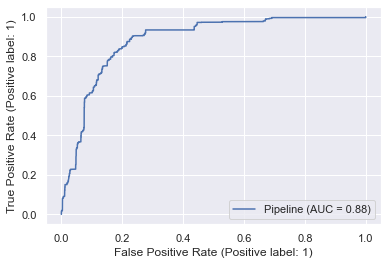

time: 1.64 s


In [211]:
plot_roc_curve(pipe_logreg_tuned1, X_test1, y_test1)

__*Threshold__

In [212]:
prob_logreg_tuned1 = pipe_logreg_tuned1.predict_proba(X_test1)[:,1]
fpr_logreg_tuned1, tpr_logreg_tuned1, threshold_logreg_tuned1 = roc_curve(y_test1, prob_logreg_tuned1)

time: 1.41 s


In [213]:
roc_logreg_tuned1_df = pd.DataFrame({'fpr': fpr_logreg_tuned1, 'tpr': tpr_logreg_tuned1, 'thr': threshold_logreg_tuned1})

time: 1 ms


In [214]:
roc_logreg_tuned1_df.head()  # checking

,fpr,tpr,thr
0,0.0,0.000000,1.999999
1,0.0,0.000214,0.999999
2,0.0,0.000815,0.999986
3,0.0,0.000861,0.999983
4,0.0,0.001007,0.999980


time: 38 ms


In [215]:
roc_logreg_tuned1_df[(roc_logreg_tuned1_df['fpr']>=0.12) & (roc_logreg_tuned1_df['fpr']<=0.19) & (roc_logreg_tuned1_df['tpr']>=0.75) & (roc_logreg_tuned1_df['tpr']<=0.82)]

,fpr,tpr,thr
1640,0.143106,0.750866,0.573671
1641,0.143106,0.751314,0.572869
1642,0.150789,0.751459,0.572670
1643,0.150789,0.752610,0.572496
1644,0.150789,0.754746,0.571547
...,...,...,...
1777,0.174810,0.819015,0.497550
1778,0.174810,0.819100,0.497531
1779,0.174810,0.819372,0.496451
1780,0.174810,0.819726,0.496413


time: 42 ms


In [216]:
roc_logreg_tuned1_df[roc_logreg_tuned1_df['thr']==0.37]

,fpr,tpr,thr


time: 27 ms


In [217]:
# thr_logreg_tuned1 = 0.496169
# thr_logreg_tuned1 = 0.37
thr_logreg_tuned1 = 0.25
ypred_thr_logreg_tuned1 = np.where(pipe_logreg_tuned1.predict_proba(X_test1)[:,1] > thr_logreg_tuned1, 1, 0)
print(classification_report(y_test1, ypred_thr_logreg_tuned1))

              precision    recall  f1-score   support

           0       0.28      0.56      0.37     19524
           1       0.99      0.95      0.97    611908

    accuracy                           0.94    631432
   macro avg       0.63      0.76      0.67    631432
weighted avg       0.96      0.94      0.95    631432

time: 2.28 s


In [218]:
confusion_matrix(y_test1, ypred_thr_logreg_tuned1)

array([[ 10893,   8631],
       [ 28226, 583682]], dtype=int64)

time: 544 ms


__*Prediction__

In [153]:
pred1a_test['city'].mode()

0    Bekasi
dtype: object

time: 3 ms


In [156]:
pred1a_test['street'].mode()

0    Cibarusah Raya
dtype: object

time: 3 ms


In [158]:
pred1a_test['is_highway'].mode()

0    t
dtype: object

time: 3 ms


In [160]:
pred1a_test['road_type'].mode()

0    2.0
dtype: float64

time: 15 ms


In [155]:
pred1a_test['city'].fillna('Bekasi', inplace=True)

time: 1.99 ms


In [157]:
pred1a_test['street'].fillna('Cibarusah Raya', inplace=True)

time: 1 ms


In [159]:
pred1a_test['is_highway'].fillna('t', inplace=True)

time: 2 ms


In [161]:
pred1a_test['road_type'].fillna(2.0, inplace=True)

time: 1 ms


In [174]:
pred1a_test

,city,street,is_highway,road_type,month,day,weekend,working_hour,high_commute,op_malam,op_ngalong,op_tidur
0,Bekasi,Hankam Raya,f,2.0,11,25,False,False,True,False,False,False
1,Bandung,Asia Afrika,t,7.0,11,29,True,False,False,True,False,False
2,Bandung,Soekarno-Hatta (Jalur Lambat),t,6.0,11,27,False,True,False,False,False,False
3,Depok,Krukut Raya,f,2.0,11,24,False,False,True,False,False,False
4,Tambun Selatan,Haji Abu Bakar,f,2.0,11,27,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
13836,Bandung,Jenderal AH Nasution,t,6.0,11,26,False,False,False,False,False,True
13837,Bekasi,Cibarusah Raya,t,2.0,11,24,False,False,False,True,False,False
13838,Depok,Muhtar Raya,t,7.0,11,24,False,True,False,False,False,False
13839,Cikarang,Cibarusah Raya,t,7.0,11,24,False,False,True,False,False,False


time: 15 ms


In [175]:
pred1a_test.isna().sum()

city            0
street          0
is_highway      0
road_type       0
month           0
day             0
weekend         0
working_hour    0
high_commute    0
op_malam        0
op_ngalong      0
op_tidur        0
dtype: int64

time: 39 ms


In [176]:
thr_logreg_tuned1 = 0.25

pipe_logreg_tuned1.fit(X1, y1)
ypred_thr_logreg_tuned1_pred = np.where(pipe_logreg_tuned1.predict_proba(pred1a_test)[:,1] > thr_logreg_tuned1, 1, 0)

time: 3min 30s


In [177]:
result_thr_logreg_tuned1 = test_df.copy()
result_thr_logreg_tuned1['Labels'] = ypred_thr_logreg_tuned1_pred
result_thr_logreg_tuned1['Labels'] = np.where(result_thr_logreg_tuned1['Labels']==1, True, False)

time: 3 ms


In [179]:
result_thr_logreg_tuned1.to_csv('TruePositive_4.csv', index=False)

time: 27 ms


In [180]:
result_thr_logreg_tuned1

,Ids,Labels
0,2e6992a84_2020-11-25_18,True
1,2e68e62f4_2020-11-29_20,True
2,2e68e81a4_2020-11-27_10,True
3,2e69eec04_2020-11-24_7,True
4,2e698e4a4_2020-11-27_8,True
...,...,...
13836,2e68dd414_2020-11-26_5,True
13837,2e698541c_2020-11-24_22,True
13838,2e69e8e0c_2020-11-24_10,True
13839,2e699a1cc_2020-11-24_18,True


time: 7 ms


## Model - X2, y2

In [186]:
X2.head()

,x,y,z,month,day,weekend,working_hour,high_commute,op_malam,op_ngalong,op_tidur
0,0.550197,0.585971,-0.594912,10,14,False,True,False,False,False,False
1,0.550197,0.585971,-0.594912,10,14,False,True,False,False,False,False
2,0.550197,0.585971,-0.594912,10,14,False,True,False,False,False,False
3,0.550197,0.585971,-0.594912,10,14,False,True,False,False,False,False
4,0.550197,0.585971,-0.594912,10,14,False,True,False,False,False,False


time: 9.99 ms


In [187]:
y2[:5]

0    1
1    1
2    1
3    1
4    1
Name: Labels, dtype: int64

time: 2.99 ms


In [191]:
logreg = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=2021, C=0.01)
smote = SMOTE(k_neighbors=5, random_state=2021)

transformer_tuned2 = ColumnTransformer([
    ('ordinal', ce.OrdinalEncoder(), ['month', 'day']),
    ('poly', PolynomialFeatures(degree=2, include_bias=False), ['x','y','z']),
    ('onehot', OneHotEncoder(drop='first'), ['weekend', 'working_hour', 'high_commute', 'op_malam', 'op_ngalong', 'op_tidur'])    
], remainder='passthrough')

pipe_logreg_tuned2 = imbPipeline([
    ('transformer', transformer_tuned2),
    ('smote', smote),
    ('logreg', logreg)
])

time: 1 ms


In [192]:
logreg_tuned2_cv = cross_val_score(pipe_logreg_tuned2, X_train_val2, y_train_val2, cv=skfold, scoring='f1')
print('CV LR Benchmark1:', logreg_tuned2_cv)
print('CV LR Benchmark1 Mean:', logreg_tuned2_cv.mean())

CV LR Benchmark1: [0.8000633  0.80143312 0.80033582 0.80224953 0.8025443 ]
CV LR Benchmark1 Mean: 0.8013252157393438
time: 10min 37s


In [193]:
pipe_logreg_tuned2.fit(X_train_val2, y_train_val2)
ypred_logreg_tuned2 = pipe_logreg_tuned2.predict(X_test2)
print(classification_report(y_test2, ypred_logreg_tuned2))

              precision    recall  f1-score   support

           0       0.07      0.79      0.13     19524
           1       0.99      0.67      0.80    611908

    accuracy                           0.68    631432
   macro avg       0.53      0.73      0.47    631432
weighted avg       0.96      0.68      0.78    631432

time: 3min 14s


In [228]:
confusion_matrix(y_test2, ypred_logreg_tuned2)

array([[ 15343,   4181],
       [200786, 411122]], dtype=int64)

time: 486 ms


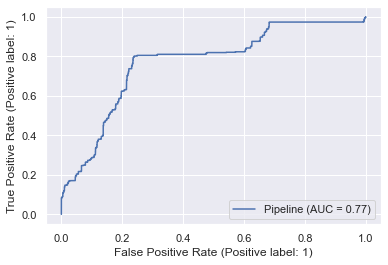

time: 901 ms


In [229]:
plot_roc_curve(pipe_logreg_tuned2, X_test2, y_test2)

In [231]:
pipe_logreg_tuned2.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ordinal', OrdinalEncoder(), ['month', 'day']),
                                   ('poly', PolynomialFeatures(include_bias=False),
                                    ['x', 'y', 'z']),
                                   ('onehot', OneHotEncoder(drop='first'),
                                    ['weekend', 'working_hour', 'high_commute',
                                     'op_malam', 'op_ngalong', 'op_tidur'])])),
  ('smote', SMOTE(random_state=2021)),
  ('logreg',
   LogisticRegression(C=0.01, class_weight='balanced', random_state=2021,
                      solver='liblinear'))],
 'verbose': False,
 'transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('ordinal', OrdinalEncoder(), ['month', 'day']),
                                 ('poly', PolynomialFeatures(include_bias=False),
                                  ['x', 

time: 11 ms


In [ ]:
hyperparam_space_logreg_tuned2 = {
    'logreg__C':[1, 0.1, 0.01, 0.001],
    'smote__k_neighbors': [3, 5, 7], 
    'logreg__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}


gridsearch_logreg_tuned2 = GridSearchCV(
    pipe_logreg_tuned2,
    param_grid = hyperparam_space_logreg_tuned2,
    cv = skfold,
    scoring = 'f1',
    n_jobs = -1,
    verbose = 1
)

gridsearch_logreg_tuned2.fit(X_train_val2, y_train_val2)

> __Part2b__

In [196]:
pred1a_test_null = pd.read_csv('pred1a_test.csv')

time: 23 ms


In [198]:
pred1a_test_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13841 entries, 0 to 13840
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          9843 non-null   object 
 1   street        9843 non-null   object 
 2   is_highway    9843 non-null   object 
 3   road_type     9843 non-null   float64
 4   month         13841 non-null  int64  
 5   day           13841 non-null  int64  
 6   weekend       13841 non-null  bool   
 7   working_hour  13841 non-null  bool   
 8   high_commute  13841 non-null  bool   
 9   op_malam      13841 non-null  bool   
 10  op_ngalong    13841 non-null  bool   
 11  op_tidur      13841 non-null  bool   
dtypes: bool(6), float64(1), int64(2), object(3)
memory usage: 730.0+ KB
time: 9 ms


In [199]:
pred1a_test_null.dropna(inplace=True)

time: 7.99 ms


In [200]:
pred1a_test_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9843 entries, 0 to 13840
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          9843 non-null   object 
 1   street        9843 non-null   object 
 2   is_highway    9843 non-null   object 
 3   road_type     9843 non-null   float64
 4   month         9843 non-null   int64  
 5   day           9843 non-null   int64  
 6   weekend       9843 non-null   bool   
 7   working_hour  9843 non-null   bool   
 8   high_commute  9843 non-null   bool   
 9   op_malam      9843 non-null   bool   
 10  op_ngalong    9843 non-null   bool   
 11  op_tidur      9843 non-null   bool   
dtypes: bool(6), float64(1), int64(2), object(3)
memory usage: 596.0+ KB
time: 9 ms


In [219]:
thr_logreg_tuned1 = 0.25

pipe_logreg_tuned1.fit(X1, y1)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal', OrdinalEncoder(),
                                                  ['month', 'day']),
                                                 ('binary', BinaryEncoder(),
                                                  ['street', 'city']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['is_highway', 'road_type',
                                                   'weekend', 'working_hour',
                                                   'high_commute', 'op_malam',
                                                   'op_ngalong',
                                                   'op_tidur'])])),
                ('smote', SMOTE(random_state=2021)),
                ('logreg',
                 Logistic

time: 3min 32s


In [220]:
ypred_thr_logreg_tuned1_pred = np.where(pipe_logreg_tuned1.predict_proba(pred1a_test_null)[:,1] > thr_logreg_tuned1, 1, 0)

time: 30 ms


In [224]:
Ids_pred1a = pd.read_csv('Ids_pred1a.csv')

time: 17 ms


In [225]:
result_thr_logreg_tuned1 = Ids_pred1a.copy()
result_thr_logreg_tuned1['Labels'] = ypred_thr_logreg_tuned1_pred
result_thr_logreg_tuned1['Labels'] = np.where(result_thr_logreg_tuned1['Labels']==1, True, False)

time: 2 ms


In [226]:
result_thr_logreg_tuned1

,Ids,Labels
0,2e6992a84_2020-11-25_18,True
1,2e68e62f4_2020-11-29_20,True
2,2e68e81a4_2020-11-27_10,True
3,2e69eec04_2020-11-24_7,True
4,2e698e4a4_2020-11-27_8,True
...,...,...
9838,2e698d7ac_2020-11-26_12,True
9839,2e68dd414_2020-11-26_5,True
9840,2e69e8e0c_2020-11-24_10,True
9841,2e699a1cc_2020-11-24_18,True


time: 7 ms


In [227]:
part2b = result_thr_logreg_tuned1.copy()

time: 1 ms


In [230]:
# part2b.to_csv('part2b.csv', index=False)

time: 19 ms


In [ ]:
print(1)